# Machine Learning Lab - Team Random Run
### Teammate: Daren Ma, Yao Liu, Yunzheng Zhao

In [1]:
import numpy as np
import pandas as pd
from sklearn import compose
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib as mpl
from rfpimp import *
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Get, asess and pre-processing the data 

Data Source: https://data.mendeley.com/datasets/h3cgnj8hft/1
Features extracted from 5000 phishing webpages and 5000 legitimate webpages, which were downloaded from January to May 2015 and from May to June 2017.


In [2]:
url = "https://raw.githubusercontent.com/darenma/data/master/phishing.csv"
phishing = pd.read_csv(url)
phishing.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


- Checking missing values and outliers

In [3]:
print(phishing.isnull().any())

id                                    False
NumDots                               False
SubdomainLevel                        False
PathLevel                             False
UrlLength                             False
NumDash                               False
NumDashInHostname                     False
AtSymbol                              False
TildeSymbol                           False
NumUnderscore                         False
NumPercent                            False
NumQueryComponents                    False
NumAmpersand                          False
NumHash                               False
NumNumericChars                       False
NoHttps                               False
RandomString                          False
IpAddress                             False
DomainInSubdomains                    False
DomainInPaths                         False
HttpsInHostname                       False
HostnameLength                        False
PathLength                      

In [4]:
def histograms(df, variables, row, col):
    fig = plt.figure()
    for i, var_name in enumerate(variables):
        sub = fig.add_subplot(row, col, i+1)
        df[var_name].hist(bins=10, ax=sub)
        sub.set_title(var_name)
    fig.tight_layout()
    plt.show()

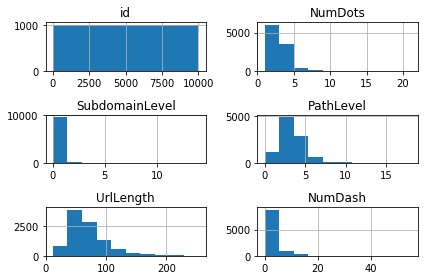

In [5]:
col = phishing.columns[:6]
histograms(phishing, phishing[col], 3, 2)

- We found that some columns has zero values, so we decided to drop such columns

In [6]:
def process_data(data):
    data = data.drop(['id', 'HttpsInHostname'], 1) 
    return data

- Train-test split

In [7]:
phishing = process_data(phishing)
target=phishing['CLASS_LABEL']
y = phishing['CLASS_LABEL']
X = phishing.drop('CLASS_LABEL', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=999)
X_train_original = X_train.copy()

# Encoding and Standardization 

- We found that the data source uses label encoding for all of the categorical features, we converted those binary label encoding to one hot encoding to compare results

In [8]:
def convert_binary_cat(phishing):
    for col in phishing.columns:
        if len(phishing[col].unique()) == 2:
            phishing.loc[phishing[col] == 1, col] = col + '_True'
            phishing.loc[phishing[col] == 0, col] = col + '_False'
    return phishing

In [9]:
X_train = convert_binary_cat(X_train)
X_test = convert_binary_cat(X_test)

- Standardization for numerical columns for better speed with SVM


In [10]:
def preprocessor_(X_train):
    all_col = X_train.columns.tolist()
    
    # Pick columns for standardization and one hot encoding
    col_encoded = []
    for col in all_col:
        if X_train[col].dtype == 'object':
            col_encoded.append(col)
    col_numeric = [i for i in all_col if i not in col_encoded]

    standardize_num = Pipeline(steps=[('scaler', preprocessing.StandardScaler())])
    onehot_encode = Pipeline(steps=[('scaler', preprocessing.OneHotEncoder())])

    preprocessor = compose.ColumnTransformer(transformers=[
        ('standard', standardize_num, col_numeric),
        ('categorical', onehot_encode, col_encoded)])
    return preprocessor

# Initial Model selection
Tune the hyperparameter of each model with random search cv and compare the models at the same time

In [11]:
def best_model():
    pipe_lr = Pipeline([('scl', preprocessor_(X_train)),
                        ('clf', LogisticRegression(random_state=42))])

    pipe_rf = Pipeline([('scl', preprocessor_(X_train)),
                        ('clf', RandomForestClassifier(random_state=42))])

    pipe_svm = Pipeline([('scl', preprocessor_(X_train)),
                         ('clf', svm.SVC(random_state=42))])

    pipe_knn = Pipeline([('scl', preprocessor_(X_train)),
                         ('clf', KNeighborsClassifier())])

    pipe_gb = Pipeline([('scl', preprocessor_(X_train)),
                        ('clf', GradientBoostingClassifier(random_state=42))])



    param_range = [1, 2, 5, 10]
    param_range_fl = [1.0, 0.5, 0.1]

    grid_params_lr = {'clf__penalty': ['l1', 'l2'],
                       'clf__C': param_range_fl,
                       'clf__solver': ['liblinear']}

    grid_params_rf = {'clf__criterion': ['gini', 'entropy'],
                       'clf__min_samples_leaf': param_range,
                       'clf__max_depth': param_range,
                       'clf__min_samples_split': param_range[1:]}

    grid_params_svm = {'clf__kernel': ['linear', 'rbf'],
                       'clf__C': param_range}

    grid_params_knn = {'clf__n_neighbors': [5, 10, 15, 20],
                       'clf__weights': ['uniform', 'distance'],
                       'clf__algorithm': ['ball_tree', 'kd_tree'],
                       'clf__leaf_size': [20, 50, 100]}

    grid_params_gb = {'clf__n_estimators': [5,50,250,500],
                      'clf__max_depth': param_range,
                      'clf__learning_rate': param_range_fl,
                      'clf__max_features':param_range}

    jobs = -1

    gs_lr = RandomizedSearchCV(estimator=pipe_lr,
                         param_distributions=grid_params_lr,
                         scoring='accuracy',
                         cv=10)

    gs_rf = RandomizedSearchCV(estimator=pipe_rf,
                         param_distributions=grid_params_rf,
                         scoring='accuracy',
                         cv=10,
                         n_jobs=jobs)

    gs_svm = RandomizedSearchCV(estimator=pipe_svm,
                          param_distributions=grid_params_svm,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=jobs)

    gs_knn = RandomizedSearchCV(estimator=pipe_knn,
                          param_distributions=grid_params_knn,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=jobs)

    gs_gb = RandomizedSearchCV(estimator=pipe_gb,
                          param_distributions=grid_params_gb,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=jobs)


    grids = [gs_lr, gs_rf, gs_svm, gs_knn, gs_gb]

    grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2: 'Support Vector Machine',
                 3: 'KNN Classifier', 4:'Gradient Boosting'}

    print('Performing model optimizations...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])
        gs.fit(X_train, y_train)
        print('Best params: %s' % gs.best_params_)
        print('Best cross-validation accuracy: %.3f' % gs.best_score_)
        if gs.best_score_ > best_acc:
            best_acc = gs.best_score_
            best_gs = gs
            best_clf = idx

    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
    print('\nBest Cross Validation Accuracy %s' % str(best_acc))
    return grids

pipelines1 = best_model()

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__C': 1.0}
Best cross-validation accuracy: 0.941

Estimator: Random Forest
Best params: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__criterion': 'entropy'}
Best cross-validation accuracy: 0.973

Estimator: Support Vector Machine
Best params: {'clf__kernel': 'rbf', 'clf__C': 10}
Best cross-validation accuracy: 0.969

Estimator: KNN Classifier
Best params: {'clf__weights': 'uniform', 'clf__n_neighbors': 5, 'clf__leaf_size': 100, 'clf__algorithm': 'kd_tree'}
Best cross-validation accuracy: 0.947

Estimator: Gradient Boosting
Best params: {'clf__n_estimators': 500, 'clf__max_features': 5, 'clf__max_depth': 5, 'clf__learning_rate': 0.5}
Best cross-validation accuracy: 0.985

Classifier with best test set accuracy: Gradient Boosting

Best Cross Validation Accuracy 0.9852


In [12]:
from sklearn.metrics import classification_report
models = ['lr', 'rf', 'svm', 'knn', 'gb']
idx = 0
for pipe in pipelines1:
    y_pred = pipe.predict(X_test)
    cr = classification_report(y_test, y_pred, digits=2)
    print(models[idx])
    idx += 1
    print(cr)
    print('')

lr
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1264
           1       0.93      0.97      0.95      1236

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500


rf
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1264
           1       0.98      0.97      0.98      1236

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500


svm
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1264
           1       0.97      0.99      0.98      1236

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500


knn
  

# Further Model Selection with Fewer Features

Apart from the prediction power, we also want the most efficient model with potential fewer features. 
Therefore, we calculated the feature correlation matrix and found the obviously correlated features. We then removed selective features and compared random forest and gradient boosting again to do an iterative model selection.

In [13]:
corr = X_train.corr()
dict_corr = dict()
for i in range(corr.shape[0]):
    for j in range(corr.shape[0]):
        if i > j:
            dict_corr[corr.index[i] + ' ' + corr.columns[j]] = corr[corr.index[i]][corr.columns[j]]
sorted(dict_corr.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('NumAmpersand NumQueryComponents', 0.8718722275852037),
 ('QueryLength NumQueryComponents', 0.8170370433882282),
 ('QueryLength NumAmpersand', 0.7638085641896879),
 ('QueryLength UrlLength', 0.649140284708603),
 ('PathLength UrlLength', 0.6459903420546582),
 ('NumNumericChars UrlLength', 0.6429942029911467),
 ('PathLength PathLevel', 0.6132246843738026),
 ('PathLength NumDash', 0.606077888049115),
 ('HostnameLength SubdomainLevel', 0.5921716506911184),
 ('HostnameLength NumDashInHostname', 0.5589530913377394)]

In [14]:
def process_data2(data):
    data = data.drop(['NumAmpersand', 'QueryLength', 'PathLevel', 'NumDash', 'SubdomainLevel',
              'NumDashInHostname', 'DomainInSubdomains', 'NumNumericChars'], 1)
    return data

In [15]:
def best_model2(X_train):
    pipe_rf = Pipeline([('scl', preprocessor_(X_train)),
                        ('clf', RandomForestClassifier(random_state=42))])

    pipe_gb = Pipeline([('scl', preprocessor_(X_train)),
                        ('clf', GradientBoostingClassifier(random_state=42))])



    param_range = [1, 2, 5, 10]
    param_range_fl = [1.0, 0.5, 0.1]

    grid_params_rf = {'clf__criterion': ['gini', 'entropy'],
                       'clf__min_samples_leaf': param_range,
                       'clf__max_depth': param_range,
                       'clf__min_samples_split': param_range[1:]}

    grid_params_gb = {'clf__n_estimators': [5,50,250,500],
                      'clf__max_depth': param_range,
                      'clf__learning_rate': param_range_fl,
                      'clf__max_features':param_range}

    jobs = -1

    gs_rf = RandomizedSearchCV(estimator=pipe_rf,
                         param_distributions=grid_params_rf,
                         scoring='accuracy',
                         cv=10,
                         n_jobs=jobs)

    gs_gb = RandomizedSearchCV(estimator=pipe_gb,
                          param_distributions=grid_params_gb,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=jobs)


    grids = [gs_rf, gs_gb]

    grid_dict = {0: 'Random Forest', 1:'Gradient Boosting'}

    print('Performing model optimizations...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])
        gs.fit(X_train, y_train)
        print('Best params: %s' % gs.best_params_)
        print('Best cross-validation accuracy: %.3f' % gs.best_score_)
        if gs.best_score_ > best_acc:
            best_acc = gs.best_score_
            best_gs = gs
            best_clf = idx

    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
    print('\nBest Cross Validation Accuracy %s' % str(best_acc))
    return grids

X_train_new = process_data2(X_train)
pipelines2 = best_model2(X_train_new)

Performing model optimizations...

Estimator: Random Forest
Best params: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__criterion': 'gini'}
Best cross-validation accuracy: 0.968

Estimator: Gradient Boosting
Best params: {'clf__n_estimators': 250, 'clf__max_features': 5, 'clf__max_depth': 10, 'clf__learning_rate': 0.5}
Best cross-validation accuracy: 0.980

Classifier with best test set accuracy: Gradient Boosting

Best Cross Validation Accuracy 0.9804


# <font color=green>Our Winner is Gradient Boosting Classifier</font>

# Model Evaluation

In [16]:
gb = pipelines1[4]
y_pred = gb.predict(X_test)

Confusion matrix, without normalization
[[1248   16]
 [  12 1224]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


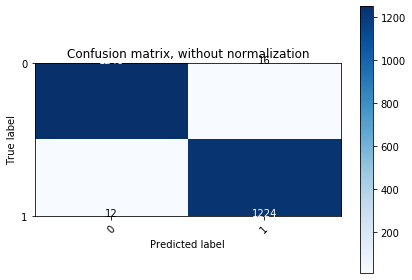

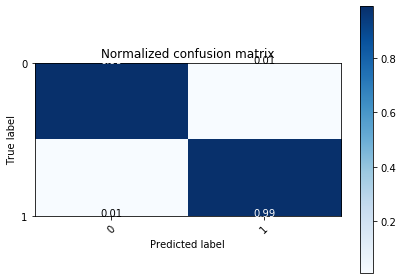

In [17]:
class_names = ['0', '1']

def plot_confusion_matrix(cm, classes,  # cited from https://medium.com/@rakeshrajpurohit/confusion-matrix-469248ed0397
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

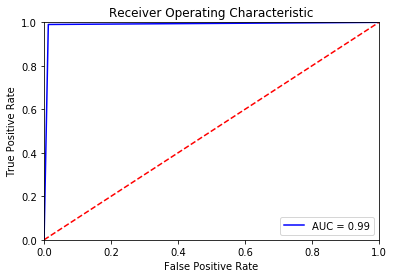

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1264
           1       0.99      0.99      0.99      1236

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



# Feature Importance
This part is feature importance analysis includes 1) sklearn GB's default importance attribute, and 2) Terence and James's rfpimp package.

### Feature importance on Gradient Boosting Classifier

Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HostnameLength', 'PathLength',
       'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords',
       'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls',
       'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction',
       'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks',
       'FrequentDomainNameMismatch', 'FakeLinkInStatusBar',
       'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail',
       'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT',
       'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'],
      dtype='object')


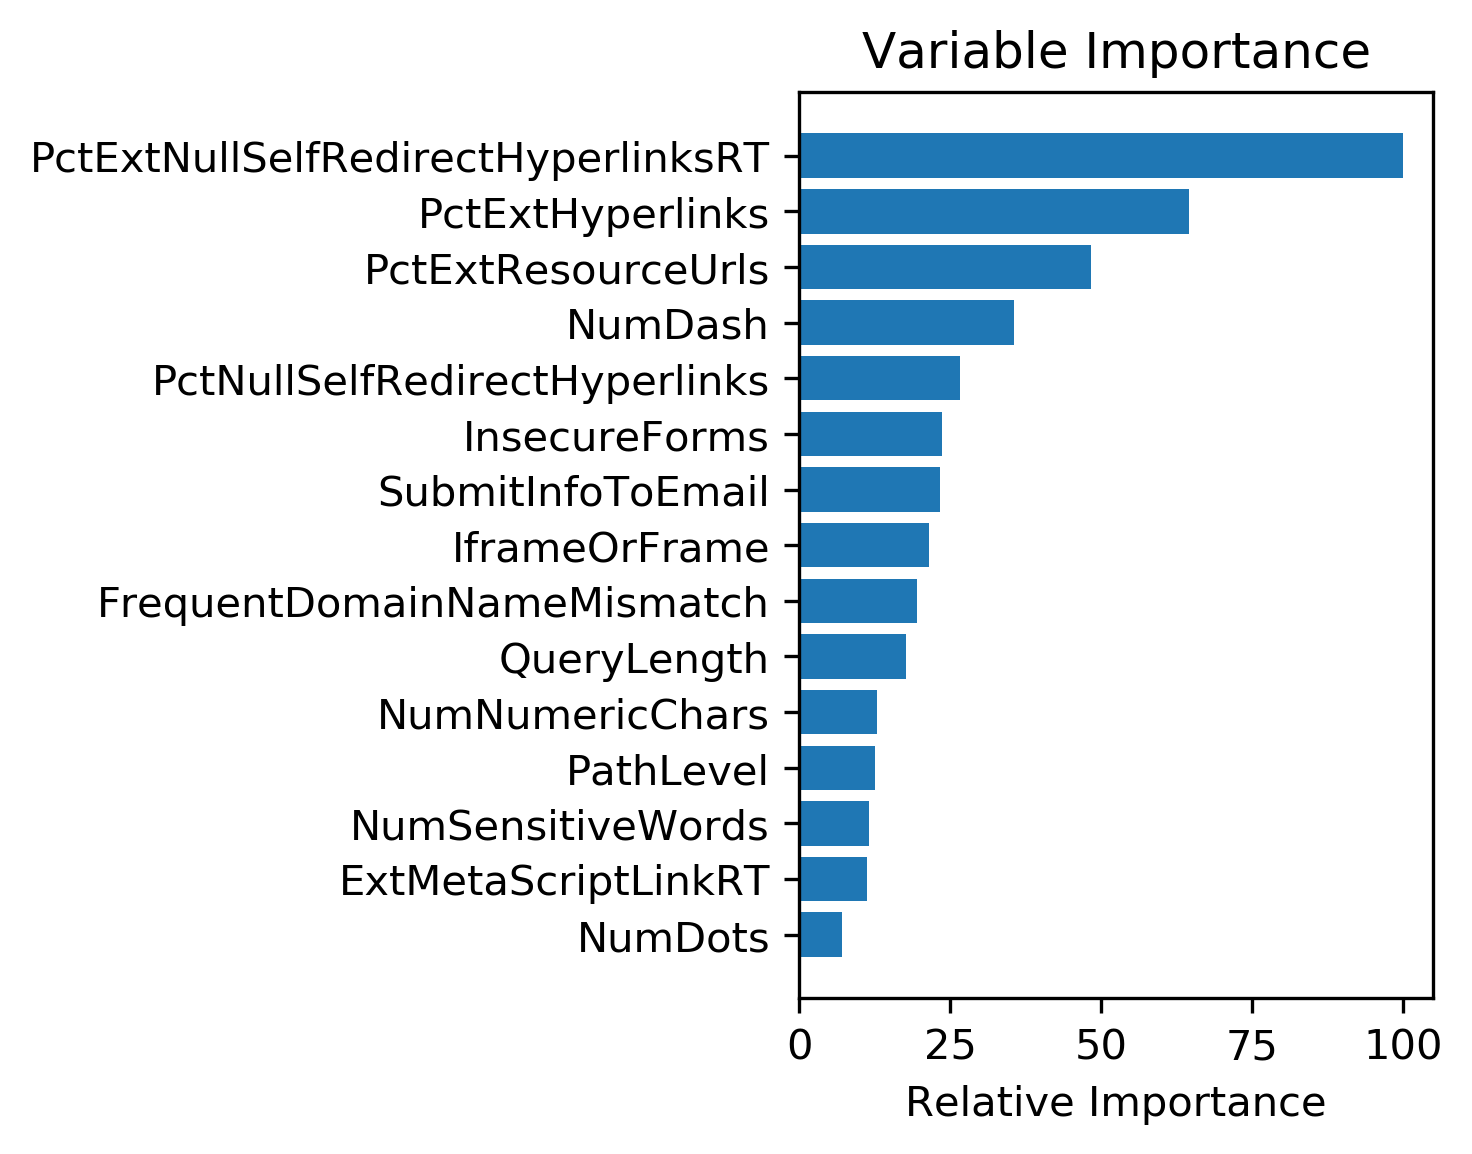

array([ 0, 45, 23,  2, 13, 21, 33, 38, 37, 28, 32,  4, 26, 25, 46])

In [20]:
final_model = GradientBoostingClassifier(n_estimators=250,max_features=5,
                                         max_depth=10,learning_rate= 0.1).fit(X_train_original, y_train)
feature_importance = final_model.feature_importances_
print(X_train.columns)
print(feature_importance/0.2322393291560225*100)
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
sorted_idx

- Compare with rfpimp feature importance based on random forest

In [21]:
def convert_cat_binary(phishing):
    for col in [i for i in phishing.columns if i != 'CLASS_LABEL']:
        if len(phishing[col].unique()) == 2:
            phishing.loc[phishing[col] == col + '_True', col] = 1
            phishing.loc[phishing[col] == col + '_False', col] = 0
    return phishing
phishing = convert_cat_binary(phishing)
X_train = convert_cat_binary(X_train)
X_test = convert_cat_binary(X_test)

In [22]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1,
                           min_samples_split=10, min_samples_leaf=5, 
                           max_depth=10, criterion='entropy')


rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
# Scikit learn top-10 important features.
sorted(list(zip(phishing.columns, rf[1].feature_importances_)), key=lambda x:x[1],reverse=True)[:12]

[('PctExtResourceUrls', 0.26304230810399953),
 ('PctExtNullSelfRedirectHyperlinksRT', 0.14121662126358894),
 ('PctExtHyperlinks', 0.09615087937857428),
 ('NumDash', 0.08079138296211036),
 ('ExtFavicon', 0.07598763013684937),
 ('NumDots', 0.075397216946159),
 ('FrequentDomainNameMismatch', 0.05126976993793718),
 ('HostnameLength', 0.03299574045606876),
 ('PathLevel', 0.027955406445999375),
 ('PctNullSelfRedirectHyperlinks', 0.024651902968809338),
 ('PathLength', 0.022489821999938722),
 ('InsecureForms', 0.018785749530493872)]

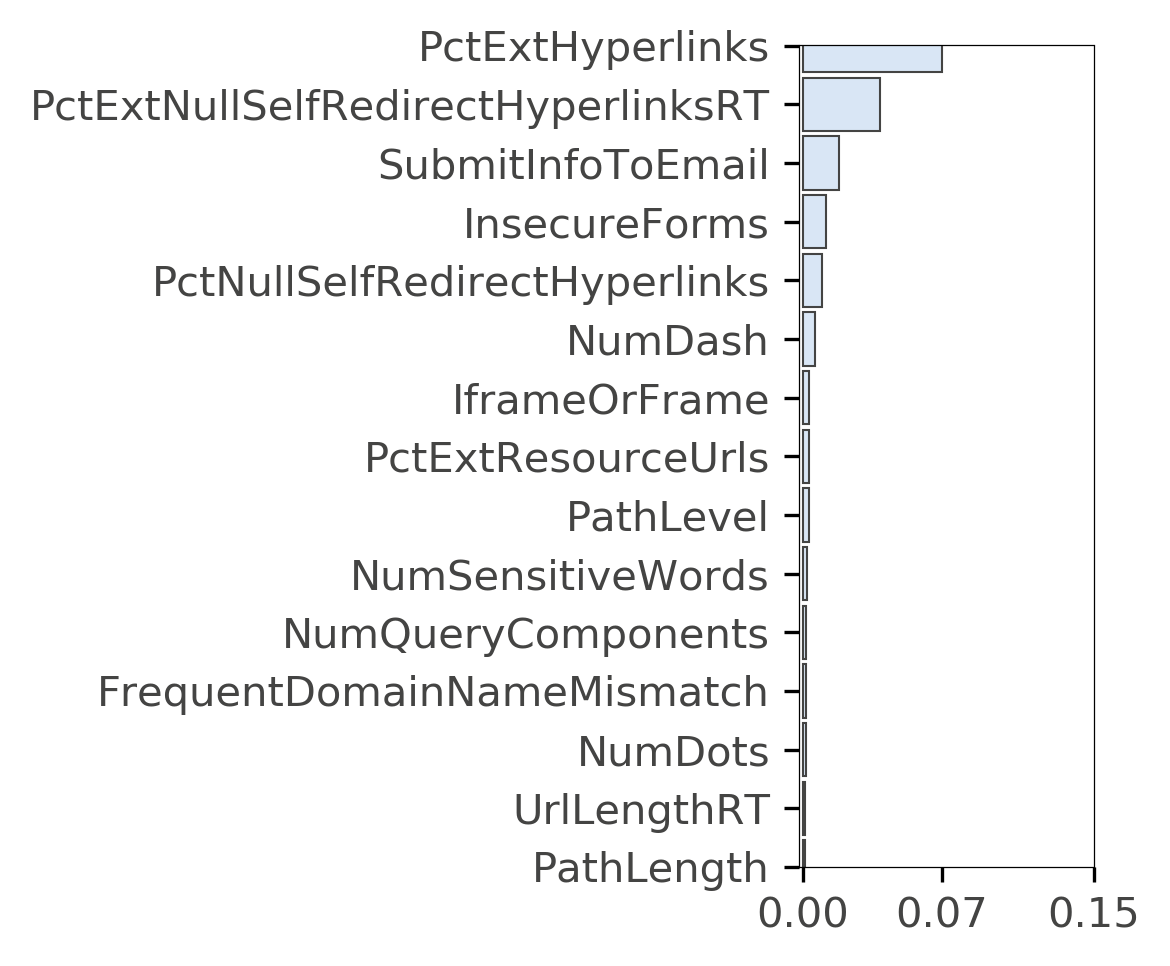

In [24]:
mpl.rcParams['figure.dpi'] = 300
imp = importances(rf, X_test, y_test)[:15] # permutation
viz = plot_importances(imp)
viz.view()

In [25]:
# Top 10 important features from rfpimp
imp.head(10)

,Importance
Feature,
PctExtHyperlinks,0.0716
PctExtNullSelfRedirectHyperlinksRT,0.0396
SubmitInfoToEmail,0.0184
InsecureForms,0.0120
PctNullSelfRedirectHyperlinks,0.0096
NumDash,0.0060
IframeOrFrame,0.0032
PctExtResourceUrls,0.0032
PathLevel,0.0028


### Summary


- We compared five supervised models and Gradient Boosting Classifier gave the best prediction.

- We are able to predict phishing site with 99% accuracy, F-1 score, precision and recall. 

- We removed highly correlated features, which did not significantly impact prediction accuracy.

- We identified the top-10 important features, which are close to the baseline knowledge given by the author of the paper 'A New Hybrid Ensemble Feature Selection Framework for Machine Learning-based Phishing Detection System'